In [ ]:
# Information Bottleneck Theory For Deep Learning.
https://arxiv.org/pdf/1503.02406
https://arxiv.org/pdf/1703.00810
Naftali Tishby라는 분이 거의 1999년도?부터 Information Bottleneck 관련해서 연구하신 분 같은데, 이걸로 Deep learning을 해석한다는 내용이다.
중간에 누군가 반박(?)하는 논문도 내서 여기 어쩌구저쩌구 말이 나오고... 또 반박하고...
https://www.dropbox.com/scl/fi/nzxsmhng8u0g5okp5nbxb/Naftali-Tishby-and-Ravid-Shwartz-Ziv-final-comment.pdf?rlkey=hoydclygga7pmc5d07fwwewm0&e=1&dl=0
진짜 너무 재밌다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅠㅠㅠ 하지만 무려 2018년도에 한창 휩쓸고 지나간 느낌이라.. 난 왜 이렇게 한발(?) 늦을까 항상,,
지금부터라도 부지런히 따라가자..

지금 구현해보는 코드는 https://github.com/stevenliuyi/information-bottleneck/blob/master/information_bottleneck.ipynb 여기 있는 내용 거의 그대로구..
왜 따라서 해보냐면, 아직 Mutual Information을 어떻게 추정한다는 것인지 잘 와닿지 않기 때문이다.

 베껴쓰기 코딩은 오랜만에 해보지만, 분명 많은 도움이 될 것이라고 생각함...

# Data Generation

Inputs: 10bits vector
Output: 0 or 1
1024개의 input이 16개의 group(mod 16)으로 나눠짐 !

16으로 나눈 나머지가 0또는 1로 associate됨 

In [ ]:
import numpy as np
from random import randint, seed

n_train = 5000
n_test = 5000 # tf에서 None Type이 안돼서 그냥 n_test 똑같게 했다 ^^,,,,

groups = np.append(np.zeros(8), np.ones(8)) # 16 gropus
np.random.seed(12)
np.random.shuffle(groups)  #=> 보면 0 / 1 8개씩을 섞어서 이제 mod에서 값을 0또는 1로 맵핑해주는 것임!

seed(123)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # input: n_sample개 만큼의 10bits
    x_int = np.zeros(n_samples)
    y_data = np.zeros((n_samples, 2))

    for i in range(n_samples):
        random_int = randint(0, 1023) # 랜덤하게 0~1023 사이의 숫자 뽑기
        x_data[i, :] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))] # random_int 2진수로 바꾸고 10자리 채워준다음 input에 넣어줌
        x_int[i] = random_int
        y_data[i, 0] = groups[random_int % 16] # 근데 bit 하나만 써도 되는 거 아닌가? 굳이..???
        y_data[i, 1] = 1 - y_data[i, 0]
    x_data = x_data.astype(np.float32)
    y_data = y_data.astype(np.float32)
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train)
x_test, y_test, x_test_int = generate_samples(n_test)

# Mutual Information (X, Y)
X, Y는 이미 주어져있으니, 확률 분포에 대한 계산이 가능함 !
$$
\begin{aligned}
    I(X;Y) &= \sum_{x\in X, y \in Y} P(x, y)log(\frac{P(x, y)}{P(x)P(y)}) \\
           &= \sum_{x\inX}[P(x, y = 0)log(\frac{P(x, y=0)}{P(x)P(y=0)}) + P(x, y = 1)log(\frac{P(x, y=1)}{P(x)P(y=1)})]\\
           &=  1024[\frac{1}{1024}log\frac{1/1024}{1/1024/2} + 0]\\
           $= 0.693

\end{aligned}
$$


# Neural Network
이제 input을 넣으면 output을 내뱉은 뉴럴넷을 만들면 됨 !

In [104]:
# ㅠㅠ언제적 텐서플로우임,,

import tensorflow as tf

def nn(tensor, n_outputs, name):

    size = tf.shape(tensor)[1]

    weight = tf.Variable(tf.random.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))

    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)

    tensor = tf.tanh(tensor, name= name)

    return tensor

def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]

    weight = tf.Variable(tf.random.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)

    return tensor

In [105]:
def mlp(x, n_neurons):
    hidden = x
    for n in range(len(n_neurons)):
        hidden = nn(hidden, n_neurons[n], 'hidden%s' % (n+1))
    y = output(hidden, 2)

    return y

def build_network(hidden_layre_neurons):
    global x, y, logits, cost, optimizer, accuracy
    
    tf.compat.v1.reset_default_graph()
    tf.compat.v1.disable_eager_execution()

    x = tf.compat.v1.placeholder(tf.float32, (5000, 10), name = 'x')
    y = tf.compat.v1.placeholder(tf.float32, (5000, 2), name = 'y')
 
    tf.compat.v1.set_random_seed(12344)
    logits = mlp(x, hidden_layre_neurons)

    logits = tf.identity(logits, name = 'logits') 


    cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = logits, labels = y), name = 'cost')

    optimizer = tf.compat.v1.train.GradientDescentOptimizer(0.1).minimize(cost)

    correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name = 'accuracy')

def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict = {x: x_test, y: y_test})
    print("Epoch {:>4}: Testing accuracy {:>.4f} - Testing Loss {:>.4f}".format(epoch, acc, loss))

# 이렇게 하면 Layer 3개에 Neuron들이 각각 8, 6, 4개
build_network([8, 6, 4])


# Mutual Information Between hidden layer
드디어 나왔다 !! 내가 계속 궁금했던 부분

$$
\begin{aligned}
    I(X;T_i) &= \sum_{x\in X, t \in T_i} P(x, t)log(\frac{P(x, t)}{P(x)P(t)}) \\
\end{aligned}
$$
$$
\begin{aligned}
    I(Y;T_i) &= \sum_{Y\in y, t \in T_i} P(y, t)log(\frac{P(y, t)}{P(y)P(t)}) \\
\end{aligned}
$$

In [128]:
from collections import Counter

def cal_mi(hidden):
    n_neurons = hidden.shape[1]
    
    # bin으로 나눠서 계산 ! 이러면 사실 정확도가 떨어짐
    n_bins = 30
    bins = np.linspace(-1, 1, n_bins + 1)
    indices = np.digitize(hidden, bins)

    pdf_x = Counter()
    pdf_y = Counter()
    pdf_t = Counter()
    pdf_xt = Counter()
    pdf_yt = Counter()

    for i in range(n_train):
        pdf_x[x_train_int[i]] += 1/ float(n_train)
        pdf_y[y_train[i, 0]] += 1 / float(n_train)

        pdf_xt[(x_train_int[i],)+tuple(indices[i, :])] += 1 / float(n_train)
        pdf_yt[(y_train[i,0],)+tuple(indices[i, :])] += 1 / float(n_train)

        pdf_t[tuple(indices[i, :])] += 1 / float(n_train)

    mi_xt = 0
    for i in pdf_xt:
        p_xt = pdf_xt[i]
        p_x = pdf_x[i[0]]
        p_t = pdf_t[i[1:]]

        mi_xt += p_xt * np.log(p_xt / p_x / p_t)

    mi_yt = 0
    for i in pdf_yt:
        p_yt = pdf_yt[i]
        p_y = pdf_y[i[0]]
        p_t = pdf_t[i[1:]]

        mi_yt += p_yt * np.log(p_yt / p_y / p_t)
    return mi_xt, mi_yt

def get_mi(hiddens):
    mi_xt_list = []
    mi_yt_list = []
    for hidden in hiddens:
        mi_xt, mi_yt = cal_mi(hidden)
        mi_xt_list.append(mi_xt)
        mi_yt_list.append(mi_yt)
    return mi_xt_list, mi_yt_list    

In [129]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.compat.v1.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

def train_with_mi(n_epochs, n_hidden_layers):
    mi_xt_all = []; mi_ty_all = []; epochs = []
    global x_train, y_train
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer()) # initialization
        hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
        for epoch in range(n_epochs):
            _, hidden_layers = sess.run([optimizer,
                                         get_hidden_layers(hidden_layer_names)],
                                        feed_dict={x: x_train, y: y_train})
                        
            if epoch % 100 == 0: print_out_summary(sess, epoch)
            if epoch % 20 == 0:
                mi_xt, mi_ty = get_mi(hidden_layers)
                mi_xt_all.append(mi_xt)
                mi_ty_all.append(mi_ty)
                epochs.append(epoch)
    return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

In [130]:
n_epochs = 3000
n_hidden_layers = 5
build_network([8,7,6,5,3])
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

2024-12-11 13:19:23.106416: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2024-12-11 13:19:23.106463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      


Epoch    0: Testing accuracy 0.4340 - Testing Loss 0.7982
Epoch  100: Testing accuracy 0.5178 - Testing Loss 0.6962
Epoch  200: Testing accuracy 0.5336 - Testing Loss 0.6917
Epoch  300: Testing accuracy 0.5344 - Testing Loss 0.6902
Epoch  400: Testing accuracy 0.5426 - Testing Loss 0.6889
Epoch  500: Testing accuracy 0.5550 - Testing Loss 0.6862
Epoch  600: Testing accuracy 0.5818 - Testing Loss 0.6796
Epoch  700: Testing accuracy 0.6650 - Testing Loss 0.6402
Epoch  800: Testing accuracy 0.7602 - Testing Loss 0.5446
Epoch  900: Testing accuracy 0.8212 - Testing Loss 0.4468
Epoch 1000: Testing accuracy 0.9214 - Testing Loss 0.2751
Epoch 1100: Testing accuracy 0.9692 - Testing Loss 0.1529
Epoch 1200: Testing accuracy 0.9832 - Testing Loss 0.0925
Epoch 1300: Testing accuracy 0.9900 - Testing Loss 0.0564
Epoch 1400: Testing accuracy 0.9962 - Testing Loss 0.0302
Epoch 1500: Testing accuracy 0.9994 - Testing Loss 0.0200
Epoch 1600: Testing accuracy 0.9994 - Testing Loss 0.0152
Epoch 1700: Te

# Visualiztion

/tmp/ipykernel_862561/3332113387.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cool')


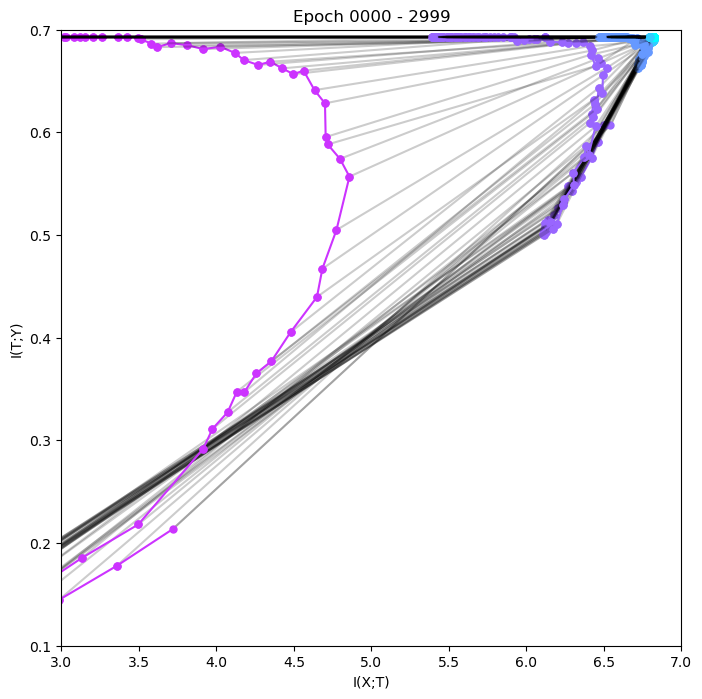

In [131]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((3,7))
ax.set_ylim((0.1,0.7))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)

cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)
HTML(anim.to_html5_video())

ax.set_title('Epoch 0000 - 2999')
fig

왜 ACC이 1이 안나오지 .. ?....
